# Predicting Car Prices
Today, we'll be using machine learning and k-nearest neighbour to find the best features and k-value for predicting the price of a car.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Reading Dataset
columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data',names=columns)

In [3]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


The numeric columns we could use for the prediction are features like horsepower, highway-mpg, city-mpg, peak-rpm etc.

## Data Cleaning 

In [4]:
# Select only ordinal columns for prediction
col = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 
       'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate','horsepower',
      'peak-rpm','city-mpg','highway-mpg','price']
new_cars = cars[col]
new_cars.head(1)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495


In [5]:
# replace ? with NaN in normalized-losses
new_cars = new_cars.replace('?',np.nan)
new_cars.head(1)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495


In [6]:
new_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  164 non-null    object 
 1   wheel-base         205 non-null    float64
 2   length             205 non-null    float64
 3   width              205 non-null    float64
 4   height             205 non-null    float64
 5   curb-weight        205 non-null    int64  
 6   engine-size        205 non-null    int64  
 7   bore               201 non-null    object 
 8   stroke             201 non-null    object 
 9   compression-rate   205 non-null    float64
 10  horsepower         203 non-null    object 
 11  peak-rpm           203 non-null    object 
 12  city-mpg           205 non-null    int64  
 13  highway-mpg        205 non-null    int64  
 14  price              201 non-null    object 
dtypes: float64(5), int64(4), object(6)
memory usage: 24.1+ KB


In [7]:
## Object to float
new_cars[['normalized-losses','bore','stroke','horsepower','peak-rpm','price']]=new_cars[['normalized-losses','bore','stroke','horsepower','peak-rpm','price']].astype(float)
new_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   normalized-losses  164 non-null    float64
 1   wheel-base         205 non-null    float64
 2   length             205 non-null    float64
 3   width              205 non-null    float64
 4   height             205 non-null    float64
 5   curb-weight        205 non-null    int64  
 6   engine-size        205 non-null    int64  
 7   bore               201 non-null    float64
 8   stroke             201 non-null    float64
 9   compression-rate   205 non-null    float64
 10  horsepower         203 non-null    float64
 11  peak-rpm           203 non-null    float64
 12  city-mpg           205 non-null    int64  
 13  highway-mpg        205 non-null    int64  
 14  price              201 non-null    float64
dtypes: float64(11), int64(4)
memory usage: 24.1 KB


In [8]:
new_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [9]:
## Drop prices with NaN since we need a price for prediction
new_cars = new_cars.dropna(subset=['price'])

In [10]:
# Fill NaN values with mean of the column
new_cars = new_cars.fillna(new_cars.mean())

In [11]:
# Normalize all columns with a range from 0 to 1 
price_og = new_cars['price']
new_cars = (new_cars - new_cars.min()) / (new_cars.max() - new_cars.min())

new_cars['price_og'] = price_og

new_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price,price_og
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,0.207959,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,0.282558,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,0.282558,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,0.219254,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,0.306142,17450.0


## Univariate Model

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [24]:
# Function for the training and error process
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
    knn = KNeighborsRegressor()
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    num_80per = int((rand_df.shape[0])*0.75)
    train_set = df[:num_80per]
    test_set = df[num_80per:]
    
    knn.fit(train_set[[train_col]], train_set[target_col])
    prediction = knn.predict(test_set[[train_col]])
    
    rmse = (mean_squared_error(test_set[target_col],prediction))**0.5
    return rmse

In [74]:
rmse_by_feature = {}
train_columns = new_cars.columns.drop('price_og').drop('price')

for col in train_columns:
    rm = knn_train_test(col,'price_og',new_cars)
    rmse_by_feature[col] = rm

In [75]:
rmse_by_feature

{'normalized-losses': 9165.372097149993,
 'wheel-base': 5600.275810224728,
 'length': 6931.079964572196,
 'width': 3816.7939591068457,
 'height': 6575.68118251772,
 'curb-weight': 2467.1015390375746,
 'engine-size': 3544.400339557994,
 'bore': 8173.167717238993,
 'stroke': 7674.212610871734,
 'compression-rate': 5676.281281220075,
 'horsepower': 3822.8885837703365,
 'peak-rpm': 7112.665899536641,
 'city-mpg': 3635.9338845128937,
 'highway-mpg': 2890.5559529029615}

We can see that the feature with the lowest rmse curb weight, which means that it is the best predictor out of these features to predict a price of a car by itself with k=5.

Top 5 best features when k=5:
1. curb-weight
2. highway-mpg
3. engine-size
4. city-mpg
5. width

#### Function with different k values

In [76]:
def knn_train_test_giveK(train_col, target_col, df):
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    num_80per = int((rand_df.shape[0])*0.75)
    train_set = df[:num_80per]
    test_set = df[num_80per:]
    
    rmse_list = {}
    k_list = [1,3,5,7,9]
    
    for k in k_list:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_set[[train_col]], train_set[target_col])
        prediction = knn.predict(test_set[[train_col]])
    
        rmse = (mean_squared_error(test_set[target_col],prediction))**0.5
        rmse_list[k] = rmse
        
    return rmse_list

In [77]:
## Test to see if function works
knn_train_test_giveK('curb-weight','price_og',new_cars)

{1: 3708.950345672838,
 3: 2512.7548895736436,
 5: 2467.1015390375746,
 7: 2654.057385936321,
 9: 2635.034409709563}

In [78]:
## Use function for every feature
column_given_k = {}

for column in train_columns:
    setr = knn_train_test_giveK(column,'price_og',new_cars)
    column_given_k[column] = setr

In [79]:
column_given_k

{'normalized-losses': {1: 9753.269432731313,
  3: 10698.960392861421,
  5: 9165.372097149993,
  7: 7924.928711328062,
  9: 7297.763011443536},
 'wheel-base': {1: 3367.494559437793,
  3: 5214.581957689807,
  5: 5600.275810224728,
  7: 5384.557726124067,
  9: 5066.717655617186},
 'length': {1: 8344.680366063443,
  3: 5981.277074345173,
  5: 6931.079964572196,
  7: 5851.891349243024,
  9: 5101.536482848944},
 'width': {1: 6384.895229997061,
  3: 4932.863130524504,
  5: 3816.7939591068457,
  7: 3361.4423824239707,
  9: 3389.7175118250443},
 'height': {1: 11902.790106261871,
  3: 8573.619849805335,
  5: 6575.68118251772,
  7: 6255.294820111567,
  9: 5494.685228394637},
 'curb-weight': {1: 3708.950345672838,
  3: 2512.7548895736436,
  5: 2467.1015390375746,
  7: 2654.057385936321,
  9: 2635.034409709563},
 'engine-size': {1: 5059.159416345763,
  3: 3825.0950275122464,
  5: 3544.400339557994,
  7: 3123.050877637719,
  9: 3091.4986679667495},
 'bore': {1: 7501.258872127176,
  3: 9582.477784260

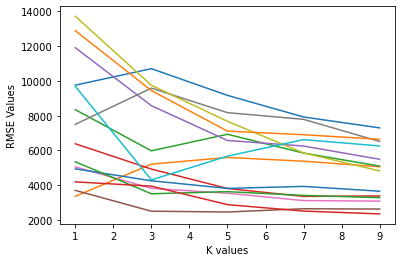

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

for key,values in column_given_k.items():
    ke = list(values.keys())
    va = list(values.values())
    
    plt.plot(ke,va)
    plt.xlabel('K values')
    plt.ylabel('RMSE Values')
plt.show()

We can see that the Univariate model with the lowest RMSE is highway-mpg with k=9.

## Multivariate Model

In [132]:
def knn_train_test_multivariate(train_col, target_col, k, df):
    np.random.seed(1)
    knn = KNeighborsRegressor(n_neighbors = k)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    num_80per = int((rand_df.shape[0])*0.75)
    train_set = df[:num_80per]
    test_set = df[num_80per:]
    
    knn.fit(train_set[train_col], train_set[target_col])
    prediction = knn.predict(test_set[train_col])
    
    rmse = (mean_squared_error(test_set[target_col],prediction))**0.5
    return rmse

In [133]:
# Two best features
knn_train_test_multivariate(['curb-weight','highway-mpg'],'price_og', 5, new_cars)

3071.6276959854845

In [134]:
# Three best features
knn_train_test_multivariate(['curb-weight','highway-mpg','engine-size'],'price_og', 5, new_cars)

2739.67417112356

In [135]:
# Four best features
knn_train_test_multivariate(['curb-weight','highway-mpg','engine-size','city-mpg'],'price_og', 5, new_cars)

2332.5369899343

In [136]:
# Five best features
knn_train_test_multivariate(['curb-weight','highway-mpg','engine-size','city-mpg','width'],'price_og', 5, new_cars)

2203.571913338637

We can see that having 5 of the best univariate features while k=5 improves our model.

Top 3:
1. Five best features
2. Four best features
3. Three best features

## Hyperparameter tuning

Now, we will use the 3 best models in the previous step and alter their k-values from 1-25 to find the optimal k value for each model.

In [148]:
three = []
four = []
five = []
for i in range(25):
    th = knn_train_test_multivariate(['curb-weight','highway-mpg','engine-size'],'price_og', i+1, new_cars)
    three.append(th)
    fo = knn_train_test_multivariate(['curb-weight','highway-mpg','engine-size','city-mpg'],'price_og', i+1, new_cars)
    four.append(fo)
    fi = knn_train_test_multivariate(['curb-weight','highway-mpg','engine-size','city-mpg','width'],'price_og', i+1, new_cars)
    five.append(fi)

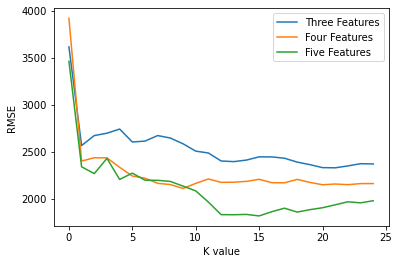

In [154]:
plt.plot(three,label='Three Features')
plt.plot(four,label='Four Features')
plt.plot(five,label='Five Features')
plt.legend()
plt.xlabel('K value')
plt.ylabel('RMSE')
plt.show()

## Conclusion

We can see that the best model for predicting the price of a car would need to include five of the best univariate features with a k-value from around 12-15.